## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt
import tqdm

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets
from ronald_bdl.models import utils

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.1

# Length scale
length_scale = 1e-2

# tau
tau = 0.25

# reg strength
reg_strength = utils.reg_strength(dropout_rate, length_scale, dataset_toy_size, tau)

print('reg_strength = ' + str(reg_strength))

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

reg_strength = tensor(9.0000e-06)


### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(length_scale)
        + '_' + str(tau)
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low-5, dataset_toy_x_high+5, 100).reshape(100, 1)
y_test = torch.pow(X_test, 3)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

y_test = y_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout_relu'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
    )
    
    uncertainty_methods['mc_dropout_tanh'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='tanh',
    )
    
    uncertainty_methods['mc_dropout_sigmoid'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='sigmoid',
    )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        progress_bar = tqdm.tqdm(range(n_epochs))

        for epoch in progress_bar: # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            progress_bar.set_description("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

[iteration 0002] loss: 577.0756:   0%|          | 0/4000 [00:00<?, ?it/s]

Now running mc_dropout_relu
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): ReLU()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



[iteration 0015] loss: 552.7277:   0%|          | 8/4000 [00:00<00:56, 70.21it/s]

final loss = tensor(77.7754, grad_fn=<MseLossBackward>)
training time = 32.57793307304382 seconds

Now running mc_dropout_tanh
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): Tanh()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



[iteration 0025] loss: 571.3314:   0%|          | 13/4000 [00:00<00:31, 126.85it/s]

final loss = tensor(83.5670, grad_fn=<MseLossBackward>)
training time = 32.60076022148132 seconds

Now running mc_dropout_sigmoid
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): Sigmoid()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



[iteration 4000] loss: 140.0379: 100%|██████████| 4000/4000 [00:32<00:00, 122.29it/s]


final loss = tensor(140.0379, grad_fn=<MseLossBackward>)
training time = 32.71206712722778 seconds



## Plot the results

/Users/se9/python/00_default/lib/python3.8/site-packages/ronald_bdl/models/fcnet.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reg_strength = torch.tensor(
/Users/se9/python/00_default/lib/python3.8/site-packages/ronald_bdl/models/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(


testing time = 0.6609830856323242 seconds

Mean = tensor([-1.4473e+02, -1.4530e+02, -1.3974e+02, -1.3302e+02, -1.2833e+02,
        -1.2528e+02, -1.2546e+02, -1.2168e+02, -1.1594e+02, -1.1237e+02,
        -1.1134e+02, -1.0695e+02, -1.0135e+02, -9.8541e+01, -9.4914e+01,
        -9.2471e+01, -8.8234e+01, -8.4025e+01, -7.9723e+01, -7.7772e+01,
        -7.3993e+01, -7.0222e+01, -6.4375e+01, -6.2394e+01, -5.9912e+01,
        -5.5384e+01, -5.2673e+01, -4.7221e+01, -4.4191e+01, -4.1144e+01,
        -3.7471e+01, -3.3552e+01, -2.9918e+01, -2.6515e+01, -2.2906e+01,
        -1.8983e+01, -1.6114e+01, -1.1914e+01, -8.7216e+00, -5.7388e+00,
        -3.8836e+00, -2.9366e+00, -2.4047e+00, -1.7224e+00, -1.1060e+00,
        -4.7579e-01,  1.2643e-02,  4.6302e-01,  1.0081e+00,  1.4894e+00,
         1.9088e+00,  2.0772e+00,  2.1995e+00,  2.2002e+00,  2.1553e+00,
         2.1331e+00,  2.1107e+00,  2.0795e+00,  2.4995e+00,  4.1907e+00,
         5.8433e+00,  7.7003e+00,  9.3548e+00,  1.0837e+01,  1.4033e+01,
 

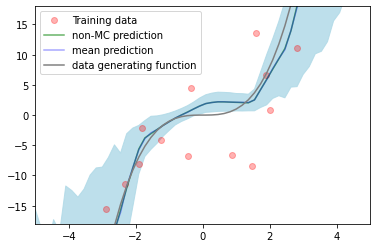

testing time = 0.4454917907714844 seconds

Mean = tensor([-57.2313, -56.0433, -55.8615, -56.8945, -57.6370, -56.4769, -57.3579,
        -57.0353, -57.1501, -57.3316, -56.6404, -57.1389, -57.7092, -56.5921,
        -54.7833, -56.1115, -55.7753, -55.5503, -55.4546, -54.8056, -55.1140,
        -54.4401, -54.6465, -53.6275, -51.8827, -49.7412, -48.3553, -47.3679,
        -45.4538, -41.2387, -39.1411, -33.8362, -30.2122, -27.3183, -22.3730,
        -18.9625, -14.8638, -11.7600,  -8.9573,  -6.6908,  -4.9773,  -3.5339,
         -2.3127,  -1.5440,  -0.7958,  -0.2613,   0.1778,   0.3846,   0.7699,
          0.8688,   0.9703,   1.2315,   1.4025,   1.7479,   1.9147,   2.2067,
          2.4903,   3.0607,   3.6212,   4.3641,   5.3909,   6.6115,   8.6511,
         10.8244,  13.9871,  17.6242,  21.7424,  26.1408,  32.1046,  37.4680,
         41.4194,  46.1046,  50.5443,  54.4995,  56.8480,  58.2264,  59.4857,
         61.1728,  62.9151,  64.1929,  61.9600,  63.3479,  62.5016,  63.9828,
         65.13

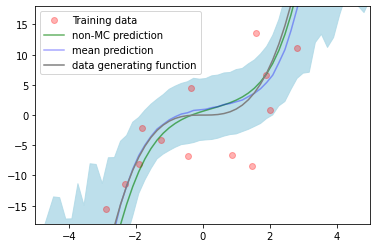

testing time = 0.41625380516052246 seconds

Mean = tensor([-38.9471, -39.9825, -39.1418, -38.9227, -39.3926, -39.0045, -39.2268,
        -39.0579, -37.7888, -38.3578, -37.7419, -37.4594, -37.7254, -37.2966,
        -37.4866, -37.5351, -36.0946, -35.4723, -36.1581, -35.1693, -34.0939,
        -34.0718, -33.3873, -32.6220, -32.4274, -31.5293, -31.3683, -29.6984,
        -29.0553, -28.5428, -27.2423, -25.0444, -24.4760, -23.1582, -21.1356,
        -19.4611, -17.9271, -16.3800, -14.7824, -13.2313, -11.6729, -10.2699,
         -8.8322,  -7.5543,  -6.5567,  -5.4106,  -4.3054,  -3.2900,  -2.1955,
         -1.1306,  -0.1769,   1.0265,   2.0007,   3.0881,   4.2685,   5.5128,
          6.8073,   8.2118,   9.5810,  11.0972,  12.9772,  14.2260,  16.6233,
         18.3562,  20.3275,  22.8891,  24.5805,  26.6130,  28.9430,  31.0022,
         32.5675,  34.2730,  36.0116,  38.4529,  38.4247,  40.9704,  41.9377,
         42.8168,  44.3216,  45.8518,  46.2011,  47.0067,  47.4288,  48.1776,
         49.6

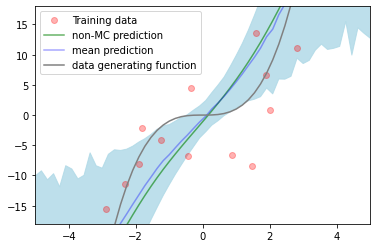

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(
        X_test, n_predictions,
        y_test=y_test,
        reg_strength=reg_strength, train_size=dataset_toy_size, length_scale=length_scale)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for metric_key, value in metrics.items():
            print(str(metric_key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low-1, dataset_toy_x_high+1)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.6)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.35)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()